In [5]:
#Capstone Project
# Import necessary libraries
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

In [44]:
#Reading the file
df = pd.read_csv("AdSmartABdata.csv")

In [46]:
df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [11]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [17]:
df.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [18]:
df.duplicated().sum()

0

In [61]:
#No dublicated and no null values
#Now based on the file, we need to define experience(exposed) and control group
# Filter out users that were not interacting
rows = df.query('yes == 1 | no == 1')

# Divide a dataframe by exposed and control group
exposed = rows.query('experiment == "exposed"')
control = rows.query('experiment == "control"')

# Calculate a number of observation in both groups
print('The exposed group dataframe has {} observations'. format(exposed.shape[0]))
print('The control group dataframe has {} observations'. format(control.shape[0]))

print('The conversion rate in the exposed group is equal to {}'.format('{0:.2f}%'.format(exposed.yes.mean()*100)))
print('The conversion rate in the control group is equal to {}'.format('{0:.2f}%'.format(control.yes.mean()*100)))

The exposed group dataframe has 657 observations
The control group dataframe has 586 observations
The conversion rate in the exposed group is equal to 46.88%
The conversion rate in the control group is equal to 45.05%


In [63]:
#Sampling distribution under the null

print('The observed difference in the conversion rate between the exposed and the control group is {}'.format('{0:.2f}%'.format((exposed.yes.mean() - control.yes.mean())*100)))

The observed difference in the conversion rate between the exposed and the control group is 1.83%


In [65]:
#With using the data, we try to get only converted one (which is Yes=1)
exposed_converted = exposed.query('yes == 1')
control_converted = control.query('yes == 1')
print('The sample sizes of the exposed group and control group are {} and {} respectively'.format(exposed.shape[0], control.shape[0]))
print('The number of conversions in the exposed group and control group is {} and {} respectively'.format(exposed_converted.shape[0],control_converted.shape[0]))

The sample sizes of the exposed group and control group are 657 and 586 respectively
The number of conversions in the exposed group and control group is 308 and 264 respectively


In [25]:
#storing number of conversions for exposed and control groups as numpy arrays
count = np.array([exposed_converted.shape[0], control_converted.shape[0]])
#storing sample sizes of exposed and control group as numpy arrays
nobs = np.array([exposed.shape[0], control.shape[0]])
#storing results of z test in variables
stat, p_val = proportions_ztest(count, nobs, alternative = 'larger')
p_form = '{0:.2f}%'.format(p_val*100)
print('P-value is equal to {}'.format(p_form))

P-value is equal to 25.92%


In [26]:
#H0, the null hypothesis can not be rejected. Conversion expectation is a failure. There are no changes in conversion either with the new add or with the dummy add, because the value is greater than 5% 
#Because we are working on categorical values, this result was created based on a binominal distribution. It is required to convert it into normal distribution. To do that, with using this 8077 record, we will create 250000 numbered sample (In the original example, 100000 was implemented)


In [66]:
# Draw 250000 samples from binominal distribution
exposed_simulation = np.random.binomial(exposed.shape[0], exposed.yes.mean(), 250000)/exposed.shape[0]
control_simulation = np.random.binomial(control.shape[0], control.yes.mean(), 250000)/control.shape[0]
p_diffs = exposed_simulation - control_simulation
diffs = np.array(p_diffs)

#Creation of normal distribution centered at zero
null_vals = np.random.normal(0, np.std(diffs), len(diffs))

In [71]:
def statplot(data, lim, obs_stat, title):
    """
    This function creates a plot, that represents sampling distribution. 
    This plot is formatted and has main statistics on it
    Arguments:
    data = array
    lim = height of the plot
    obs_stat = observed statistic
    title = chart title
    """
    
    #Create a kdeplot
    plt.figure(figsize=(12,4), tight_layout=True)
    ax = sns.kdeplot(data, linewidth = 0.8, color = 'black')
    
    # Simple formatting
    frame = ['right', 'left', 'top']
    for i in frame:
        ax.spines[i].set_visible(False)

    plt.title(title)
    plt.ylabel('')
    plt.yticks([], [])
    
    # Legend
    line = Line2D([0], [0], color='orange', linestyle = '-', label='observed statistic')
    line_dashed = Line2D([0], [0], color='gray', linestyle = '--', label='mean and standard deviation')
    plt.legend(handles=[line, line_dashed], loc='upper left');
    
    # Create a list of 3 standard deviation to the left and to the right and mean
    std_list = []
    std_list_format = []
    for i in range(-3,4):
        std_dev = np.std(data) * i + np.mean(data)
        std_list.append(std_dev)
        std_list_format.append('{0:.3f}'.format(std_dev) + '\n {} std'.format(i))
        
    # Create a list of corresponding y values
    data_x, data_y = ax.lines[0].get_data()
    height = []
    for i in std_list:
        height.append(np.interp(i, data_x, data_y))
        
    # Plotting vertical lines representing std deviations 
    for a, b in zip(std_list, height):
        plt.axvline(a, 0, b/lim, color = 'gray', alpha = 1, linewidth = 0.8, linestyle = '--')
        plt.plot(a, b, marker = 'o', color = 'yellow')
    
    # Plotting observed statistic
    obs_line_height = np.interp(obs_stat, data_x, data_y)
    plt.axvline(obs_stat, 0, obs_line_height/lim, color = 'orange', alpha = 1, linewidth = 0.8, linestyle = '-')
    plt.plot(obs_stat, obs_line_height, marker = 'o', color = 'orange')
            
    # Plotting x ticks
    x_ticks = std_list
    x_labels = std_list_format
    plt.xticks(x_ticks, x_labels)
    plt.ylim(0,lim)

In [72]:
def shading(data, left, right, color):
    
    """
    This function shades areas of the kde plot.
    Arguments:
    data = array
    left = left boundary of the area to be shaded
    right = right boundary of the area to be shaded
    color = color
    """
    
    #Shading areas
    kde = stats.gaussian_kde(data)
    shade = np.linspace(left, right, 100)
    plt.fill_between(shade, kde(shade), color = color, alpha = 0.5);

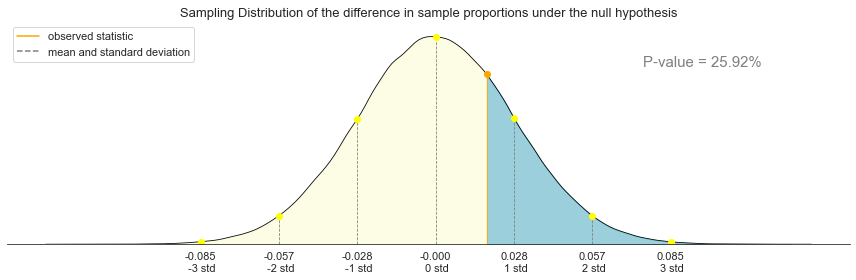

In [73]:
# Plotting the sampling distribution
statplot(null_vals, 15, obs_diff, 'Sampling Distribution of the difference in sample proportions under the null hypothesis')
shading(null_vals, obs_diff, null_vals.max(),'#3aa1bb')
shading(null_vals, null_vals.min(), obs_diff,'#fafcca')
plt.text(0.075, 12, "P-value = {}".format(p_form), color = 'gray', size = 15);

In [40]:
#We implemented a normal distribution via binomial distribution. When the observed part is orange, the test shows the given figure. This observed value, stays in  the middle of the +- 1 standard diversion. 
#The observations shows lower diversion with respect to mean and standard deviation. For this reason, H0 is accepted. And this result is correlated with the p-value.
